# Apply parameters shift rules to train quantum model using [TorchQuantum](https://github.com/mit-han-lab/torchquantum).
<p align="left">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/torchquantum_logo.jpg?raw=true" alt="torchquantum Logo" width="250">
</p>

Tutorial Author: Zirui Li, Hanrui Wang


###Outline
1. Introduction to Parameters Shift Rules.
2. Train a model with parameters shift rules.
3. A simple 2 qubit model for a simple 2 classification task.



In this tutorial, you can learn parameters shift rules and how to use parameters shift rules to calculate gradients and use the gradient to train a model.

##Introduction to Parameters Shift Rules

###Back Propagation

Previously, our quantum model was based on qiskit and pytorch. Once we did an inference of the model, pytorch will automatically build a computaional graph. We can calculate the gradients of each node in the computational graph in a reversed order based on the chain rule. This is called back propagation.
<div align="center">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/figs/bp.png?raw=true" alt="conv-full-layer" width="300">
</div>

###Parameters Shift Rules

As we all know, when executing a quantum circuit on a real quantum machine, we can not observe the intermdiate quantum state. So, back propagation to calculate gradients are impossible when our circuits run on real quantum machines. Parameters shift rules offer us a technique to calculate gradients only by doing inference. For a circuit function $f(\theta)$, we can calculate $f'(\theta)$ by shifting $\theta$ twice and minus one result by the other and multiply with a factor. The figure below describes the workflow of how to calculate the gradient of a parameter in a 4-qubit circuit.

<div align="center">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/figs/ps.png?raw=true" alt="conv-full-layer" width="600">
</div>

Suppose an $m$-qubit quantum circuit is parametrized by $n$ parameters $\theta=[\theta_1,\cdots,\theta_i,\cdots,\theta_n]$, the expectation value of measures of this circuit can be represented by a circuit function,
$$f(\theta)=\langle\psi|U(\theta_i)^{\dagger}\widehat{Q}U(\theta_i)|\psi\rangle, \quad f(\theta)\in\mathbb{R}^{m}, \theta\in\mathbb{R}^n.
$$
where $\theta_i$ is the scalar parameter whose gradient is to be calculated, and $U(\theta_i)$ is the gate where $\theta_i$ lies in. 

Here, for notation simplicity, we have already absorbed the unitaries before $U(\theta_i)$ into $\langle\psi|$, $|\psi\rangle$.
Unitaries after $U(\theta_i)$ and observables are fused into $\widehat{Q}$.

Usually, the rotation gates used in QNN can be written in the form $U(\theta_i)=e^{-\frac{i}{2}\theta_i H}$. Here $H$ is the Hermitian generator of $U$ with only 2 unique eigenvalues +1 and -1.

In this way, the gradients of the circuit function $f$ with respect to $\theta_i$ are,
$$    \begin{aligned}
    &\frac{\partial f(\theta)}{\partial \theta_i}=\frac{1}{2}\Big(f\big(\theta_+\big)-f\big(\theta_{-}\big)\Big), \\ &\theta_+=[\theta_1,\cdots,\theta_i+\frac{\pi}{2},\cdots,\theta_n], \theta_{-}=[\theta_1,\cdots,\theta_i-\frac{\pi}{2},\cdots,\theta_n],
    \end{aligned}
$$
where $\theta_+$ and $\theta_{-}$ are the **positive shift** and **negative shift** of $\theta$.

Note that this parameter shift rule is **fundamentally different** from any numerical difference methods that only approximate the directional derivatives.
Instead, the equation calculates the **exact** gradient w.r.t $\theta_i$ without any approximation errors or numerical issues. 

We apply $\text{softmax}$ on $f(\theta)$ as the predicted probability for each class. 
Then we calculate the cross entropy between the predicted probability distribution $p$ and the target distribution $t$ as the classification loss $\mathcal{L}$, 
$$    \mathcal{L}(\theta)=-t^T\cdot\texttt{softmax}(f(\theta))=-\sum_{j=1}^m t_j \log{p_j},\quad p_j=\frac{e^{f_j(\theta)}}{\sum_{j=1}^m e^{f_j(\theta)}}.
$$

Then the gradient of the loss function with respect to $\theta_i$ is $\frac{\partial\mathcal{L}(\theta)}{\partial \theta_i}=\big(\frac{\partial\mathcal{L}(\theta)}{\partial f(\theta)}\big)^T\frac{\partial f(\theta)}{\partial \theta_i}$.

Here $\frac{\partial f(\theta)}{\partial \theta_i}$ can be calculated on real quantum computer by the parameter shift rules, and $\frac{\partial\mathcal{L}(\theta)}{\partial f(\theta)}$ can be efficiently calculated on classical devices using backpropagation supported by automatic differentiation frameworks, e.g., PyTorch and TensorFlow.

Now we derive the parameter shift rules used in our QNN models.

Assume $U(\theta_i)=R_X(\theta_i),R_X(\alpha)=e^{-\frac{i}{2}\alpha X}$, where $X$ is the Pauli-X matrix.

Firstly, the RX gate is,
$$    \begin{aligned}
R_X(\alpha)&=e^{-\frac{i}{2}\alpha X}=\sum_{k=0}^{\infty}(-i\alpha/2)^kX^k/k!\\
&=\sum_{k=0}^{\infty}(-i\alpha/2)^{2k}X^{2k}/(2k)!+\sum_{k=0}^{\infty}(-i\alpha/2)^{2k+1}X^{2k+1}/(2k+1)!\\
&=\sum_{k=0}^{\infty}(-1)^k(\alpha/2)^{2k}I/(2k)!-i\sum_{k=0}^{\infty}(-1)^k(\alpha/2)^{2k+1}X/(2k+1)!\\
&=\cos(\alpha/2)I-i\sin(\alpha/2)X.
\end{aligned}
$$

Let $\alpha=\frac{\pi}{2}$, $R_X(\pm\frac{\pi}{2})=\frac{1}{\sqrt{2}}(I\mp iX)$.

As $f(\theta)=\langle\psi|R_X(\theta_i)^{\dagger}\widehat{Q}R_X(\theta_i)|\psi\rangle$, $R_X(\alpha)R_X(\beta)=R_X(\alpha+\beta)$, and $\frac{\partial}{\partial \alpha}R_X(\alpha)=-\frac{i}{2}XR_X(\alpha)$,
we have
$$\begin{aligned}
\frac{\partial f(\theta)}{\partial \theta_i}
% &=\langle\psi|\frac{\partial}{\partial \theta_i}R_X(\theta_i)^{\dagger}\widehat{Q}R_X(\theta_i)|\psi\rangle+\langle\psi|R_X(\theta_i)^{\dag}\widehat{Q}\frac{\partial}{\partial \theta_i}R_X(\theta_i)|\psi\rangle\\
=&\langle\psi|R_X(\theta_i)^{\dagger}(-\frac{i}{2}X)^{\dagger}\widehat{Q}R_X(\theta_i)|\psi\rangle+\langle\psi|R_X(\theta_i)^{\dagger}\widehat{Q}(-\frac{i}{2}X)R_X(\theta_i)|\psi\rangle\\
% &=\frac{1}{2}(\langle\psi|R_X(\theta_i)^{\dagger}(-iX)^{\dagger}\widehat{Q}R_X(\theta_i)|\psi\rangle+\langle\psi|R_X(\theta_i)^{\dagger}\widehat{Q}(-iX)R_X(\theta_i)|\psi\rangle)\\
=&\frac{1}{4}(\langle\psi|R_X(\theta_i)^{\dagger}(I-iX)^{\dagger}\widehat{Q}(I-iX)R_X(\theta_i)|\psi\rangle\\&-\langle\psi|R_X(\theta_i)^{\dagger}(I+iX)^{\dagger}\widehat{Q}(I+iX)R_X(\theta_i)|\psi\rangle)\\
=&\frac{1}{2}(\langle\psi|R_X(\theta_i)^{\dagger}R_X(\frac{\pi}{2})^{\dagger}\widehat{Q}R_X(\frac{\pi}{2})R_X(\theta_i)|\psi\rangle\\&-\langle\psi|R_X(\theta_i)^{\dagger}R_X(-\frac{\pi}{2})^{\dagger}\widehat{Q}R_X(-\frac{\pi}{2})R_X(\theta_i)|\psi\rangle)\\
=&\frac{1}{2}(f(\theta_+)-f(\theta_-)).
\end{aligned}
$$

Without loss of generality, the derivation holds for all unitaries of the form $e^{-\frac{i}{2}\alpha H}$, e.g., RX, RY, RZ, XX, YY, ZZ, where $H$ is a Hermitian matrix with only 2 unique eigenvalues +1 and -1.


##Train a model with parameters shift rules

###Installation
Firstly, install qiskit.

In [ ]:
!pip install qiskit==0.32.1

     |████████████████████████████████| 6.1 MB 7.5 MB/s 
     |████████████████████████████████| 17.9 MB 565 kB/s 
     |████████████████████████████████| 237 kB 47.9 MB/s 
     |████████████████████████████████| 207 kB 51.1 MB/s 
     |████████████████████████████████| 2.1 MB 40.3 MB/s 
     |████████████████████████████████| 634 kB 49.0 MB/s 
     |████████████████████████████████| 1.6 MB 45.4 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 37.5 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
     |████████████████████████████████| 943 kB 43.9 MB/s 
     |████████████████████████████████| 3.6 MB 44.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 6.4 MB 20.2 MB/s 
  Created wheel for qiskit: filename=qiskit-0.32.1-py3-none-any.whl size=11777 sha256=c8dd0aa33407d766de6e21a79c560a28d3aaed47ab5efde37ac60f61f0fc3275
  Stored in directory: /root/.cache/pip/whee

Download and cd to the repo.

In [ ]:
!git clone https://github.com/mit-han-lab/torchquantum.git

Cloning into 'torchquantum'...
remote: Enumerating objects: 10900, done.
remote: Counting objects: 100% (7692/7692), done.
remote: Compressing objects: 100% (3901/3901), done.
remote: Total 10900 (delta 3851), reused 7185 (delta 3382), pack-reused 3208
Receiving objects: 100% (10900/10900), 5.19 MiB | 16.99 MiB/s, done.
Resolving deltas: 100% (5818/5818), done.


In [ ]:
%cd torchquantum

/content/torchquantum


Install torch-quantum.

In [ ]:
!pip install --editable .

Obtaining file:///content/torchquantum
     |████████████████████████████████| 11.2 MB 12.1 MB/s 
     |████████████████████████████████| 81 kB 10.9 MB/s 
     |████████████████████████████████| 895 kB 45.1 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 
     |████████████████████████████████| 58 kB 1.6 MB/s 
     |████████████████████████████████| 296 kB 3.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Running setup.py develop for torchquantum
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Change PYTHONPATH and install other packages.

In [ ]:
%env PYTHONPATH=.

env: PYTHONPATH=.


Run the following code to store a qiskit token. You can replace it with your own token from your IBMQ account if you like.



In [ ]:
from qiskit import IBMQ
IBMQ.save_account('51a2a5d55d3e1d9683ab4f135fe6fbb84ecf3221765e19adb408699d43c6eaa238265059c3c2955ba59328634ffbd88ba14d5386c947d22eb9a826e40811d626', overwrite=True)

In [ ]:
!pip install matplotlib==3.1.3

     |████████████████████████████████| 13.1 MB 6.1 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchquantum 0.1.0 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!ls artifact

aerbackend.py  example2  example4  example6  README.md
example1       example3  example5  example7


In [ ]:
!cp artifact/aerbackend.py ../../usr/local/lib/python3.7/dist-packages/qiskit/providers/aer/backends/ -r

In [8]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import torchquantum as tq
import torchquantum.functional as tqf
from torchquantum.layer.layers import SethLayer0

from torchquantum.dataset import MNIST
from torch.optim.lr_scheduler import CosineAnnealingLR

### Build a quantum model
Our 4-qubit quantum model contains an encoder that can encode a 4x4 image to quantum state; a quantum layer RZZ+RY+RZZ+RY, 16 parameters in total; and PauliZ measure on each qubit.

In [9]:
class QFCModel(tq.QuantumModule):
    def __init__(self):
        super().__init__()
        self.n_wires = 4
        self.encoder = tq.GeneralEncoder(
            tq.encoder_op_list_name_dict['4x4_ryzxy'])

        self.arch = {'n_wires': self.n_wires, 'n_blocks': 2, 'n_layers_per_block': 2}
        self.q_layer = SethLayer0(self.arch)

        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        q_device = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz)
        x = F.avg_pool2d(x, 6).view(bsz, 16)

        if use_qiskit:
            x = self.qiskit_processor.process_parameterized(
                q_device, self.encoder, self.q_layer, self.measure, x)
        else:
            self.encoder(q_device, x)
            self.q_layer(q_device)
            x = self.measure(q_device)

        x = x.reshape(bsz, 4)

        return x

### Build the function of parameters shift rules

The function can shift the parameters and calculate the gradients to the expectation value of each measure for each parameter. It returns both the expectaion values and the gradient for each parameter.

In [10]:
def shift_and_run(model, inputs, use_qiskit=False):
    param_list = []
    for param in model.parameters():
        param_list.append(param)
    grad_list = []
    for param in param_list:
        param.copy_(param + np.pi * 0.5)
        out1 = model(inputs, use_qiskit)
        param.copy_(param - np.pi)
        out2 = model(inputs, use_qiskit)
        param.copy_(param + np.pi * 0.5)
        grad = 0.5 * (out1 - out2)
        grad_list.append(grad)
    return model(inputs, use_qiskit), grad_list

Set whether using gpu, using cuda, number of epochs, optimizer and scheduler. Initialize the model and the MNIST-36 classification dataset.

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = QFCModel().to(device)
n_epochs = 15
optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)

dataset = MNIST(
    root='./mnist_data',
    train_valid_split_ratio=[0.9, 0.1],
    digits_of_interest=[3, 6],
    n_test_samples=3000,
    n_train_samples=5000
)

dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=256,
        sampler=sampler,
        num_workers=8,
        pin_memory=True)

[2023-09-12 07:53:28.866] Only use the front 5000 images as TRAIN set.
[2023-09-12 07:53:28.966] Only use the front 3000 images as TEST set.


###Train the model.

During each training step, we calculated the gradients twice. First we use back propagation and second we use parameters shift rules.

In [12]:
grads_bp = []
grads_ps = []

def train_and_return_grad(dataflow, model, device, optimizer):
    for feed_dict in dataflow['train']:
        inputs = feed_dict['image'].to(device)
        targets = feed_dict['digit'].to(device)
        
        # calculate gradients via back propagation
        outputs = model(inputs)
        prediction = outputs.reshape(-1, 2, 2).sum(-1).squeeze()
        loss = F.nll_loss(F.log_softmax(prediction, dim=1), targets)
        optimizer.zero_grad()
        loss.backward()
        grad_bp = []
        for i, param in enumerate(model.q_layer.parameters()):
            grad_bp.append(param.grad.item())

        # calculate gradients via parameters shift rules
        with torch.no_grad():
            outputs, grad_list = shift_and_run(model, inputs)
        outputs.requires_grad=True
        prediction = outputs.reshape(-1, 2, 2).sum(-1).squeeze()
        loss = F.nll_loss(F.log_softmax(prediction, dim=1), targets)
        optimizer.zero_grad()
        loss.backward()
        grad_ps = []
        for i, param in enumerate(model.q_layer.parameters()):
            param.grad = torch.sum(grad_list[i] * outputs.grad).to(dtype=torch.float32, device=param.device).view(param.shape)
            grad_ps.append(param.grad.item())

        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')
        grads_bp.append(grad_bp)
        grads_ps.append(grad_ps)

def valid_test(dataflow, split, model, device, qiskit=False):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict['image'].to(device)
            targets = feed_dict['digit'].to(device)

            outputs = model(inputs, use_qiskit=qiskit)
            prediction = F.log_softmax(outputs.reshape(-1, 2, 2).sum(-1).squeeze(), dim=1)

            target_all.append(targets)
            output_all.append(prediction)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")

for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train_and_return_grad(dataflow, model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])
    # valid
    valid_test(dataflow, 'valid', model, device)
    scheduler.step()

# test
valid_test(dataflow, 'test', model, device, qiskit=False)

Epoch 1:
0.005 0.9950294494628906
valid set accuracy: 0.3219917012448133
valid set loss: 0.8985593914985657
Epoch 2:
0.0049453690018345149719
valid set accuracy: 0.36016597510373444
valid set loss: 0.8457769155502319
Epoch 3:
0.0047838636441065028674
valid set accuracy: 0.4464730290456432
valid set loss: 0.792057454586029
Epoch 4:
0.0045225424859373685277
valid set accuracy: 0.537759336099585
valid set loss: 0.7392197251319885
Epoch 5:
0.0041728265158971455605
valid set accuracy: 0.5892116182572614
valid set loss: 0.6949657797813416
Epoch 6:
0.00375.7015460133552551
valid set accuracy: 0.6190871369294606
valid set loss: 0.6624241471290588
Epoch 7:
0.0032725424859373687749
valid set accuracy: 0.6423236514522822
valid set loss: 0.6419368386268616
Epoch 8:
0.0027613211581691349373
valid set accuracy: 0.6572614107883817
valid set loss: 0.629072368144989
Epoch 9:
0.0022386788418308670791
valid set accuracy: 0.6697095435684647
valid set loss: 0.620841920375824
Epoch 10:
0.0017274575140626327

### Plot and compare the gradients

We have recorded two sets of gradients calculated by back propagation and parameters shift rules respectively. Now let's plot these gradients and we can valid that the gradients calculated by parameters shift rules are exactly the same as those calculated by back propagation. 

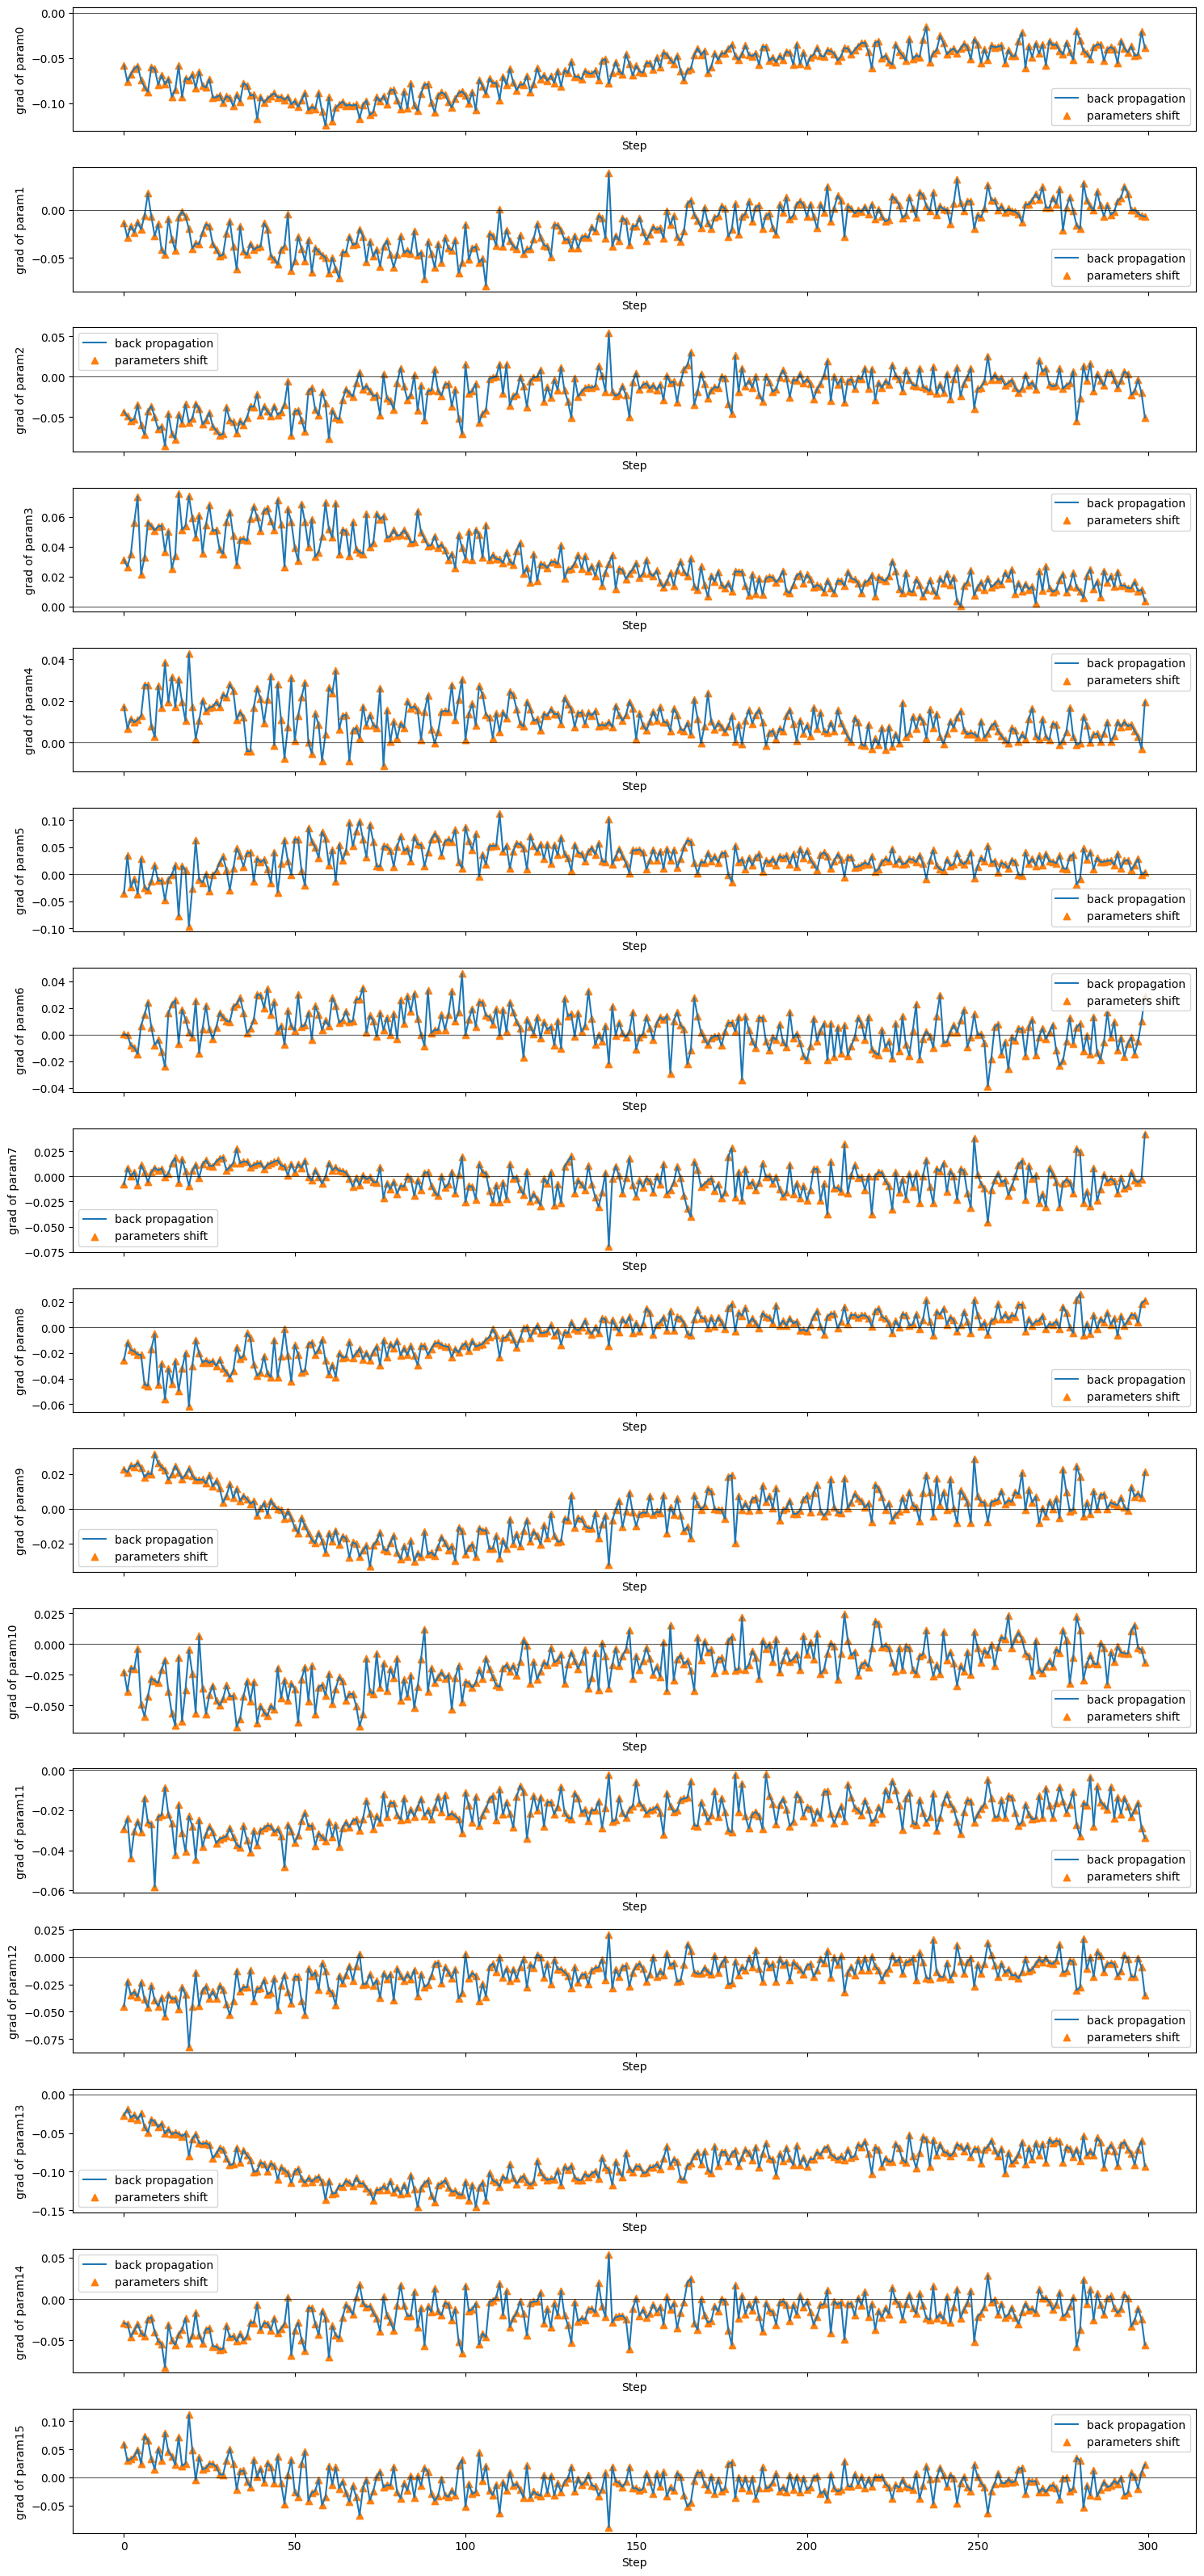

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

grads_bp = np.array(grads_bp)
grads_ps = np.array(grads_ps)

n_steps = grads_bp.shape[0]
n_params = grads_bp.shape[1]

fig, ax_list = plt.subplots(n_params, 1, sharex=True, figsize=(15, 2 * n_params))

for i, ax in enumerate(ax_list):
  ax.plot(grads_bp[:, i], c="#1f77b4", label="back propagation")
  ax.scatter(range(n_steps), grads_ps[:, i], c="#ff7f0e", marker="^", label="parameters shift")
  ax.set_ylabel("grad of param{0}".format(i))
  ax.set_xlabel("Step")
  ax.legend()
  ax.axhline(color='black', lw=0.5)

plt.tight_layout()
plt.show()


## A simple 2 qubit model for a simple 2 classification task

Firstly we create a dataset. The dataset is a simple 2 classification dataset from [Jiang et al. (2020)](https://arxiv.org/pdf/2006.14815.pdf).

<div align="center">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/figs/2cls.png?raw=true" alt="conv-full-layer" width="200">
</div>

In [ ]:
from torchpack.datasets.dataset import Dataset

class Classification2Dataset(torch.utils.data.Dataset):
    def __init__(self, num=11):
        self.data = []
        self.target = []
        sum0 = 0
        sum1 = 0
        for x in np.linspace(0, 1, num=num):
            for y in np.linspace(0, 1, num=num):
                self.data.append(torch.tensor([x, y]))
                if (x**2 + y**2 <= 0.55**2 or (x-1)**2 + (y-1)**2 <= 0.55**2):
                    self.target.append(1)
                    sum1 = sum1 + 1
                else:
                    self.target.append(0)
                    sum0 = sum0 + 1
            print(self.target[-num:])

    def __getitem__(self, idx):
        return {'data': self.data[idx], 'target': self.target[idx]}

    def __len__(self):
        return len(self.target) - 1

class Simple2Class(Dataset):
    def __init__(self):
        train_dataset = Classification2Dataset()
        valid_dataset = Classification2Dataset(num=10)
        datasets = {'train': train_dataset, 'valid': valid_dataset, 'test': valid_dataset}
        super().__init__(datasets)


Then we create our quantum circuit
<div align="center">
<img src="https://github.com/mit-han-lab/torchquantum/blob/master/figs/q2model.png?raw=true" alt="conv-full-layer" width="400">
</div>

The circuit only contains three trainable parameters. When executing the model, we firstly transform the input (x, y) to the phase $\arcsin(\sqrt{x+y-xy})$ and feed the phase to an RY gate. This is the encoding. After the ansatz, the 2 expectation values from 2 measures are the circuit outputs. Outside the circuit, we add a logsoftmax function to the output and get the predictions of each class.

In [ ]:
class Q2Model(tq.QuantumModule):
    class Ansatz(tq.QuantumModule):
        def __init__(self):
            super().__init__()
            self.n_wires = 2
            self.op1 = tq.RZ(has_params=True, trainable=True)
            self.op2 = tq.RY(has_params=True, trainable=True)
            self.op3 = tq.RY(has_params=True, trainable=True)
            self.op4 = tq.CNOT(has_params=False, trainable=False)
        
        def forward(self, q_device: tq.QuantumDevice):
            self.q_device = q_device
            self.op1(self.q_device, wires=0)
            self.op2(self.q_device, wires=1)
            self.op3(self.q_device, wires=0)
            self.op4(self.q_device, wires=[0, 1])

    def __init__(self):
        super().__init__()
        self.n_wires = 2
        self.q_device = tq.QuantumDevice(n_wires=self.n_wires)
        self.encoder = tq.GeneralEncoder([{'input_idx': [0], 'func': 'ry', 'wires': [0]}])

        self.ansatz = self.Ansatz()

        self.measure = tq.MeasureAll(tq.PauliZ)

    def forward(self, x, use_qiskit=False):
        bsz = x.shape[0]
        data = 2 * torch.arcsin(torch.sqrt(x[:, 0] + x[:, 1] - 2 * x[:, 0] * x[:, 1])).reshape(bsz, 1)

        if use_qiskit:
            data = self.qiskit_processor.process_parameterized(
                self.q_device, self.encoder, self.ansatz, self.measure, data)
        else:
            self.encoder(self.q_device, data)
            self.ansatz(self.q_device)
            data = self.measure(self.q_device)

        data = data.reshape(bsz, 2)

        return data



Load the dataset.

In [ ]:
dataset = Simple2Class()
dataflow = dict()
for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=10,
        sampler=sampler,
        num_workers=8,
        pin_memory=True)

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Define train and valid function. The model is a 2-qubit model so there is a slightly difference to the process of the circuit output.

In [ ]:
def train_2qubit(dataflow, model, device, optimizer, qiskit=False, input_name = 'data', target_name = 'target'):
    for feed_dict in dataflow['train']:
        inputs = feed_dict[input_name].to(device)
        targets = feed_dict[target_name].to(device)

        with torch.no_grad():
            outputs, grad_list = shift_and_run(model, inputs, use_qiskit=qiskit)
        outputs.requires_grad=True
        prediction = F.log_softmax(outputs, dim=1)
        loss = F.nll_loss(prediction, targets)
        optimizer.zero_grad()
        loss.backward()
        for i, param in enumerate(model.parameters()):
            param.grad = torch.sum(grad_list[i] * outputs.grad).to(dtype=torch.float32, device=param.device).view(param.shape)
        optimizer.step()
        print(f"loss: {loss.item()}", end='\r')


def valid_test_2qubit(dataflow, split, model, device, qiskit=False, input_name = 'data', target_name = 'target'):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow[split]:
            inputs = feed_dict[input_name].to(device)
            targets = feed_dict[target_name].to(device)

            outputs = model(inputs, use_qiskit=qiskit)
            prediction = F.log_softmax(outputs, dim=1)

            target_all.append(targets)
            output_all.append(prediction)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = F.nll_loss(output_all, target_all).item()

    print(f"{split} set accuracy: {accuracy}")
    print(f"{split} set loss: {loss}")


Train and valid the model on ibmq_quito. You need to import `QiskitProcessor` from `torchquantum.plugin` to create a processor that handles your access to real quantum computer. You can set whether use real quantum computer or qiskit's noise model, and the backend of your quantum computer. Call `model.set_qiskit_processor` to attach the processor to your model.

In [ ]:
from torchquantum.plugin import QiskitProcessor
model = Q2Model().to(device)
processor_real_qc = QiskitProcessor(use_real_qc=True, backend_name='ibmq_quito')
model.set_qiskit_processor(processor_real_qc)

n_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=5e-2, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train_2qubit(dataflow, model, device, optimizer, qiskit=True)
    print(optimizer.param_groups[0]['lr'])
    # valid
    valid_test_2qubit(dataflow, 'valid', model, device, qiskit=True)
    scheduler.step()
# test
valid_test_2qubit(dataflow, 'test', model, device, qiskit=True)


Epoch 1:


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/qiskit/circuit/quantumcircuit.py:933: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)
[2022-03-02 05:03:08.183] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 05:03:08.472] After transpile: {'depth': 9, 'size': 14, 'width

Job Status: job has successfully run


[2022-03-02 09:07:04.863] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:07:04.885] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:10:45.202] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:10:45.220] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:16:00.892] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:16:00.912] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:19:42.755] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:19:42.778] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:23:10.114] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:23:10.137] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:24:51.741] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:24:51.767] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:28:21.188] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:28:21.242] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:32:01.063] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:32:01.088] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:35:51.696] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:35:51.770] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:45:21.062] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:45:21.132] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 09:55:17.874] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 09:55:17.901] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 10:05:40.990] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 10:05:41.011] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 11:46:53.672] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 11:46:53.694] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 11:56:33.439] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 11:56:33.463] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 12:07:13.294] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 12:07:13.314] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 12:16:33.349] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 12:16:33.373] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 12:20:43.430] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 12:20:43.499] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 12:30:34.169] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 12:30:34.252] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 12:36:42.971] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 12:36:42.991] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 12:40:23.251] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 12:40:23.276] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 13:08:24.755] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 13:08:24.779] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 13:54:44.675] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 13:54:44.696] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 13:58:23.983] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 13:58:24.006] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:09:04.009] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:09:04.079] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:12:44.205] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:12:44.226] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:16:23.556] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:16:23.577] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:20:04.063] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:20:04.083] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:23:44.058] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:23:44.151] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:28:15.393] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:28:15.414] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:32:06.613] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:32:06.637] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:42:25.762] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:42:25.783] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:52:56.361] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:52:56.387] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 14:53:56.366] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 14:53:56.393] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:05:35.743] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:05:35.783] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:15:45.472] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:15:45.492] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:17:24.834] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:17:24.852] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:27:16.382] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:27:16.405] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:29:50.433] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:29:50.458] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:31:56.050] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:31:56.072] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:34:26.703] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:34:26.724] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:36:45.595] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:36:45.618] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:39:15.354] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:39:15.378] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:48:56.005] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:48:56.029] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 15:50:45.708] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 15:50:45.727] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:00:26.978] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:00:27.000] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:02:36.243] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:02:36.269] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:03:16.094] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:03:16.115] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:05:05.797] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:05:05.822] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:06:56.090] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:06:56.113] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:16:36.369] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:16:36.393] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:18:26.440] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:18:26.463] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:20:26.218] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:20:26.243] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:27:16.190] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:27:16.210] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:29:16.272] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:29:16.334] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:39:15.345] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:39:15.370] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:41:15.622] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:41:15.646] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:43:36.314] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:43:36.340] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:46:06.862] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:46:06.887] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:48:25.597] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:48:25.616] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 16:50:56.397] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 16:50:56.425] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:02:46.871] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:02:46.896] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:13:13.351] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:13:13.373] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:13:58.825] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:13:58.849] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:15:47.488] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:15:47.510] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:17:15.990] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:17:16.099] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:27:06.069] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:27:06.092] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:37:17.048] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:37:17.073] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:39:06.751] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:39:06.776] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:48:56.162] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:48:56.180] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:51:16.778] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:51:16.803] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:53:46.496] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:53:46.519] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:56:06.057] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:56:06.081] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 17:58:36.793] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 17:58:36.819] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:02:55.920] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:02:55.945] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:04:46.666] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:04:46.690] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:05:26.258] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:05:26.308] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:06:07.303] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:06:07.331] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:07:44.036] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:07:44.058] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:09:19.642] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:09:19.667] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:18:56.005] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:18:56.026] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:28:46.057] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:28:46.083] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:38:27.342] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:38:27.410] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:48:35.734] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:48:35.756] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run
0.05


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
[2022-03-02 18:51:06.781] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:51:06.812] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:53:27.365] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:53:27.445] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:55:46.501] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:55:46.526] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:58:16.855] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:58:16.883] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:58:56.647] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:58:56.674] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 18:59:49.658] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 18:59:49.680] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:03:20.134] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:03:20.161] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:04:56.306] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:04:56.332] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:05:36.655] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:05:36.681] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:09:06.636] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:09:06.657] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run
valid set accuracy: 0.9494949494949495
valid set loss: 0.47831726414734255
Epoch 2:


[2022-03-02 19:09:46.487] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:09:46.519] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:12:16.753] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:12:16.773] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:15:15.180] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:15:15.210] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:17:36.772] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:17:36.817] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:20:36.374] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:20:36.398] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:23:07.068] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:23:07.129] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:23:47.123] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:23:47.144] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:25:26.498] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:25:26.522] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:26:56.630] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:26:56.653] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:27:37.407] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:27:37.431] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:31:06.752] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:31:06.779] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:33:37.382] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:33:37.403] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:35:57.615] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:35:57.640] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:38:27.033] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:38:27.052] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:40:47.160] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:40:47.185] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:41:27.189] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:41:27.213] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:43:07.037] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:43:07.057] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:44:47.291] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:44:47.318] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:45:26.740] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:45:26.761] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:48:57.187] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:48:57.214] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:49:36.542] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:49:36.565] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:52:26.689] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:52:26.780] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:54:56.648] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:54:56.675] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:57:16.345] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:57:16.369] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 19:59:36.692] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 19:59:36.713] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:03:46.903] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:03:46.974] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:04:37.384] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:04:37.409] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:05:28.159] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:05:28.183] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:06:07.325] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}


[2022-03-02 20:06:07.548] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:09:37.298] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:09:37.331] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:10:17.646] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:10:17.672] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:12:41.411] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:12:41.437] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:15:06.674] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:15:06.700] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:17:26.494] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:17:26.517] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:19:47.699] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:19:47.810] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:20:27.033] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:20:27.050] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:21:06.326] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:21:06.385] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:24:51.052] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:24:51.098] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:25:37.601] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:25:37.627] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:28:07.233] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:28:07.259] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:30:27.964] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:30:27.988] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:32:46.987] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:32:47.014] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:35:17.957] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:35:17.979] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:37:37.626] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:37:37.650] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:38:23.240] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:38:23.261] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:41:58.185] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:41:58.206] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:44:27.284] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:44:27.310] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:46:47.400] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:46:47.422] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:49:18.053] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:49:18.079] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:51:58.016] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:51:58.112] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:52:37.781] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:52:37.801] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:53:17.565] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:53:17.589] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:56:47.625] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:56:47.644] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:57:27.651] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:57:27.747] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 20:58:07.759] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 20:58:07.783] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}


Job Status: job has successfully run


[2022-03-02 21:02:36.724] Before transpile: {'depth': 5, 'size': 7, 'width': 4, 'n_single_gates': 4, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'ry': 3, 'rz': 1, 'cx': 1, 'measure': 2}}
[2022-03-02 21:02:36.746] After transpile: {'depth': 9, 'size': 14, 'width': 7, 'n_single_gates': 11, 'n_two_gates': 1, 'n_three_more_gates': 0, 'n_gates_dict': {'sx': 5, 'rz': 6, 'cx': 1, 'measure': 2}}
